In [1]:
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt
import control as ctrl
from ipywidgets import interact, FloatSlider
import matplotlib.ticker as mticker
from functions import ControlFunctions
from control.matlab import bode
from control import ctrb, obsv
from ipywidgets import interact, FloatSlider, VBox
from scipy.optimize import minimize

In [2]:
def itae_pid_tuning(sys_tf, wn_values):
    s = ctrl.TransferFunction.s
    pid_params = []

    for wn in wn_values:
        itae_poly = s**7 + 2.217*wn*s**6 + 6.745*wn**2*s**5 + 9.349*wn**3*s**4 + 11.58*wn**4*s**3 + 8.68*wn**5*s**2 + wn**7
        itae_sys = itae_poly / wn**7
        pid_params.append(itae_sys)

    return pid_params

In [3]:
def format_axes(ax):
    ax.xaxis.set_major_formatter(mticker.ScalarFormatter(useMathText=True))
    ax.xaxis.get_major_formatter().set_scientific(True)
    ax.xaxis.get_major_formatter().set_powerlimits((0, 0))
    ax.yaxis.set_major_formatter(mticker.ScalarFormatter(useMathText=True))
    ax.yaxis.get_major_formatter().set_scientific(True)
    ax.yaxis.get_major_formatter().set_powerlimits((0, 0))

In [4]:
def plot_bode(sys_closed_loop):
    w, mag, phase = signal.bode((sys_closed_loop.num[0][0], sys_closed_loop.den[0][0]))

    plt.figure()
    ax1 = plt.subplot(2, 1, 1)
    plt.semilogx(w, mag)
    plt.title('Bode Plot')
    plt.ylabel('Magnitude (dB)')
    plt.grid(True, which="both", ls="--")
    format_axes(ax1)

    ax2 = plt.subplot(2, 1, 2)
    plt.semilogx(w, phase)
    plt.xlabel('Frequency (rad/s)')
    plt.ylabel('Phase (degrees)')
    plt.grid(True, which="both", ls="--")
    format_axes(ax2)

    plt.show()


In [5]:
def plot_rlocus(sys_tf):
    plt.figure()
    ctrl.rlocus(sys_tf)
    plt.title('Lugar das Raízes')
    plt.xlabel('Parte Real (seconds^{-1})')
    plt.ylabel('Parte Imaginária (seconds^{-1})')
    plt.grid(True)
    ax = plt.gca()
    format_axes(ax)
    plt.show()

In [6]:
def plot_poles(sys_tf):
    poles = ctrl.poles(sys_tf)
    zeros = ctrl.zeros(sys_tf)
    
    plt.figure()
    plt.scatter(np.real(zeros), np.imag(zeros), s=50, marker='o', color='b', label='Zeros')
    plt.scatter(np.real(poles), np.imag(poles), s=50, marker='x', color='r', label='Polos')
    plt.title('Polos e Zeros da Malha Aberta')
    plt.xlabel('Parte Real')
    plt.ylabel('Parte Imaginária')
    plt.axhline(0, color='black', linewidth=0.5)
    plt.axvline(0, color='black', linewidth=0.5)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.legend()
    plt.show()

In [7]:
def plot_response(sys_tf, step_amplitude):
    G_scaled = sys_tf * step_amplitude
    t, y = ctrl.step_response(G_scaled)
    y_degress = y * (180 / np.pi)

    plt.figure()
    plt.plot(t, y_degress)
    plt.xlabel('Tempo (s)')
    plt.ylabel('Ângulo (graus)')
    plt.title('Resposta com Amplitude')
    plt.grid()
    plt.show()

In [8]:
def itae_criteria(params, sys_tf_adjusted, step_amplitude):
    Kp, Ki, Kd = params
    pid = ctrl.TransferFunction([Kd, Kp, Ki], [1, 0])
    sys_cl = ctrl.feedback(pid * sys_tf_adjusted)
    t, y = ctrl.step_response(sys_cl * step_amplitude)
    y_degress = y * (180 / np.pi)
    itae = np.trapz(t * np.abs(y_degress), t)
    return itae

In [9]:
def itae_pid_tuning(sys_tf, wn_values):
    """
    Calcula os ganhos do controlador PID utilizando fórmulas de sintonia ITAE para sistemas de ordem superior.
    para diferentes valores de wn.
    """
    s = ctrl.TransferFunction.s
    pid_params = []

    for wn in wn_values:
        itae_poly = s**7 + 2.217*wn*s**6 + 6.745*wn**2*s**5 + 9.349*wn**3*s**4 + 11.58*wn**4*s**3 + 8.68*wn**5*s**2 + wn**7
        itae_sys = itae_poly / wn**7
        pid_params.append(itae_sys)

    return pid_params

In [10]:
def plot_root_locus(A, B, C, D, poles):
    """ Plot the root locus for given system matrices and a list of poles. """
    fig, ax = plt.subplots(figsize=(10, 6))
    for pole_set in [poles[i:i+6] for i in range(0, len(poles), 6)]:
        K = ctrl.place(A, B, pole_set)
        A_new = A - B.dot(K)
        sys = ctrl.ss(A_new, B, C, D)
        ctrl.root_locus(sys, Plot=True, ax=ax)
    ax.set_title('Root Locus for Varying Pole Configurations')
    ax.set_xlabel('Real Axis')
    ax.set_ylabel('Imaginary Axis')
    plt.show()

In [11]:
def routh_hurwitz(coeffs):
    n = len(coeffs)
    m = (n + 1) // 2
    routh = np.zeros((n, m))

    routh[0, :] = coeffs[0::2]
    routh[1, :len(coeffs[1::2])] = coeffs[1::2]

    for i in range(2, n):
        for j in range(m - 1):
            routh[i, j] = (routh[i - 1, 0] * routh[i - 2, j + 1] - routh[i - 2, 0] * routh[i - 1, j + 1]) / routh[i - 1, 0]

        if np.all(routh[i, :] == 0):
            # Special case when the entire row is zero
            routh[i, :] = routh[i - 1, :]
            break

        if routh[i, 0] == 0:
            routh[i, 0] = 1e-12

    return routh

<>:341: SyntaxWarning: invalid escape sequence '\p'
<>:343: SyntaxWarning: invalid escape sequence '\p'
<>:346: SyntaxWarning: invalid escape sequence '\p'
<>:341: SyntaxWarning: invalid escape sequence '\p'
<>:343: SyntaxWarning: invalid escape sequence '\p'
<>:346: SyntaxWarning: invalid escape sequence '\p'
C:\Users\fabricio.levy\AppData\Local\Temp\ipykernel_6088\2954400769.py:341: SyntaxWarning: invalid escape sequence '\p'
  plt.plot(t, xs_obs[:, 2], label='$\psi$ Observado')
C:\Users\fabricio.levy\AppData\Local\Temp\ipykernel_6088\2954400769.py:343: SyntaxWarning: invalid escape sequence '\p'
  plt.title('Valores Observados de $\psi$')
C:\Users\fabricio.levy\AppData\Local\Temp\ipykernel_6088\2954400769.py:346: SyntaxWarning: invalid escape sequence '\p'
  plt.ylabel('$\psi$ (graus)')
c:\Users\fabricio.levy\anaconda3\Lib\site-packages\scipy\signal\_filter_design.py:1109: BadCoefficients: Badly conditioned filter coefficients (numerator): the results may be meaningless
  b, a = nor

mf 42299.4
m0 41035.45769936651
m1 976.0489689526529
m2 210.99849178684752
m3 76.89483989398744
k0 2052090.9570207312
k1 919678.1227481287
k2 552707.1612457132
h0 -0.3794971155896977
h1 0.007518749184033169
h2 0.19322441084974268
h3 0.2802636924663934
I0 29990.833333333332
If 35914.65323677757
omega1 30.696023898050406
omega2 51.18089431673596
zeta 0.0006229749843392434
c1 37.32968582634893
c2 13.455127727560775
k 15000
cd 120
<StateSpace>: sys[0]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']
States (6): ['x[0]', 'x[1]', 'x[2]', 'x[3]', 'x[4]', 'x[5]']

A = [[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00
       0.00000000e+00  0.00000000e+00]
     [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
       1.00000000e+00  0.00000000e+00]
     [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
       0.00000000e+00  1.00000000e+00]
     [-9.42245883e+02  0.00000000e+00  9.80000000e+00 -3.82457100e-02
       0.00000000e+00  0.00000000e+00]
     [ 

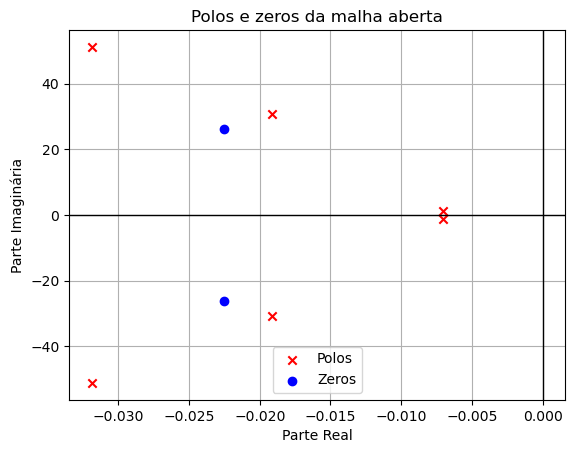

Polinômio Característico do Sistema: [1.00000000e+00 1.16064519e-01 3.56348995e+03 2.10491358e+02
 2.47445232e+06 3.49594066e+04 4.32739644e+06]
Tabela de Routh-Hurwitz:
True
Local das Raízes do Sistema:
Mt 71299.4
Hcm 0.7825622897892864
Fc 45845.80761316873
My 71754.40036600085


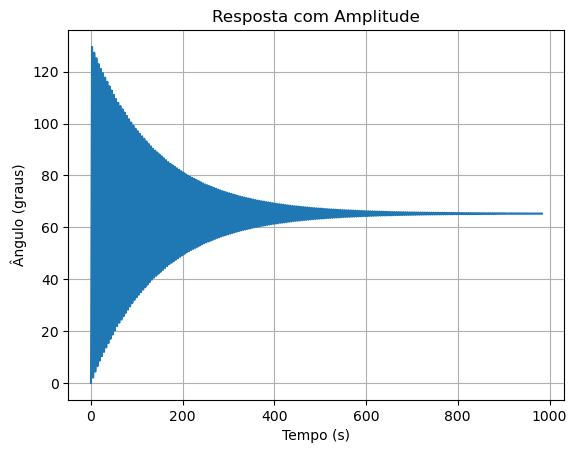

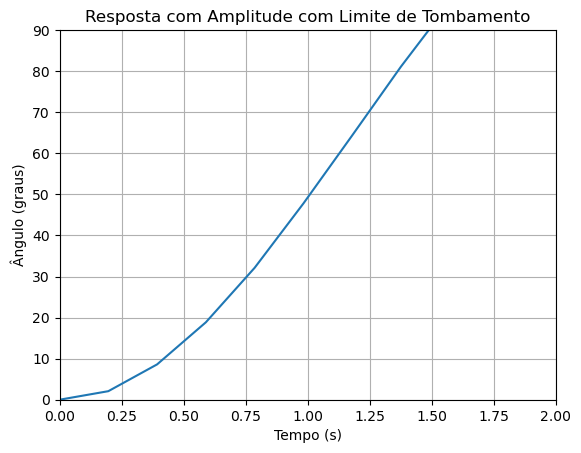

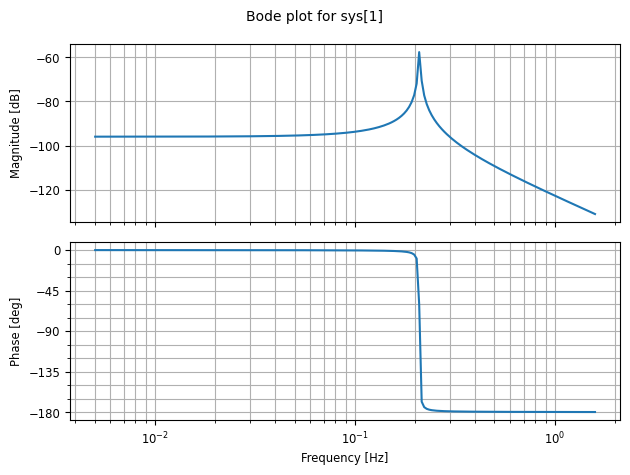

O sistema é controlável? True
O sistema é observável? True
Tabela de Routh-Hurwitz:
[[1.00000000e+00 3.56348995e+03 2.47445232e+06 4.32739644e+06]
 [1.16064519e-01 2.10491358e+02 3.49594066e+04 0.00000000e+00]
 [1.74991798e+03 2.17324566e+06 4.32739644e+06 0.00000000e+00]
 [6.63493383e+01 3.46723890e+04 0.00000000e+00 0.00000000e+00]
 [1.25878534e+06 4.32739644e+06 0.00000000e+00 0.00000000e+00]
 [3.44442962e+04 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [4.32739644e+06 0.00000000e+00 0.00000000e+00 0.00000000e+00]]


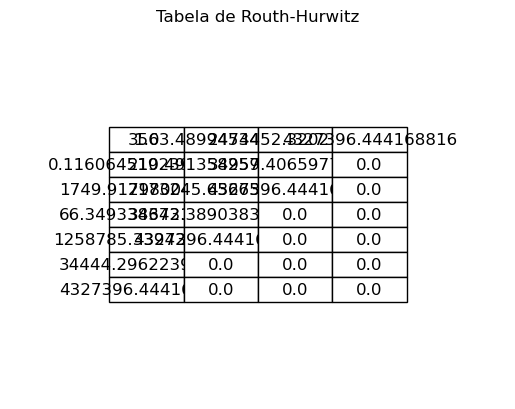

Matriz de Trnasição e dos Termos Forçantes
[[ 9.98202051e-01  3.42461076e-13  1.86998903e-05  1.95260991e-03
   1.33838806e-16  1.21804073e-08]
 [ 1.58416035e-12  9.95004373e-01  1.86896034e-05  6.19119255e-16
   1.95047771e-03  1.21763566e-08]
 [ 5.08213072e-07  1.09804927e-07  9.99996648e-01  3.31025722e-10
   7.15360626e-11  1.95382501e-03]
 [-1.83983865e+00  7.00936044e-10  1.91355557e-02  9.98127372e-01
   3.42452541e-13  1.86997191e-05]
 [ 3.24238987e-09 -5.10924504e+00  1.91146602e-02  1.58413668e-12
   9.94879993e-01  1.86894323e-05]
 [ 5.20057397e-04  1.12304036e-04 -3.43139527e-03  5.08200412e-07
   1.09800365e-07  9.99969197e-01]]
[[ 1.95268289e-03  1.33841586e-16  1.21804909e-08  1.90815313e-06
   4.35873464e-20  5.95007221e-12]
 [ 6.19126966e-16  1.95059932e-03  1.21764402e-08  2.01628856e-19
   1.90710345e-06  5.94874312e-12]
 [ 3.31031906e-10  7.15382912e-11  1.95385183e-03  1.61704522e-13
   3.49488500e-14  1.90875422e-06]
 [-1.79794943e-03  3.42461076e-13  1.86998903e-

interactive(children=(FloatSlider(value=-0.1, description='p1_real', max=10.0, min=-10.0, step=0.01), FloatSli…

Kcr encontrado: 31730000.0


In [12]:
def main():
    
    fx = ControlFunctions()

    OUTPUT = '../output/'

    g = 9.8
    M_vazio = 29000
    L = 2.9
    C = 17
    H = 2
    rho_fluido = 715
    hf = 2 * 0.6
    mf = rho_fluido * L * C * hf
    print('mf', mf)
    # quit()

    # m0 = fx.massa_i(mf, 0, hf, L)
    m1 = fx.massa_i(mf, 1, hf, L)
    m2 = fx.massa_i(mf, 2, hf, L)
    m3 = fx.massa_i(mf, 3, hf, L)
    m0 = mf - m1 - m2 - m3
    print('m0', m0)
    print('m1', m1)
    print('m2', m2)
    print('m3', m3)


    k0 = fx.calcular_ki(hf, L, g, mf, 0)
    k1 = fx.calcular_ki(hf, L, g, mf, 1)
    k2 = fx.calcular_ki(hf, L, g, mf, 2)

    print('k0', k0)
    print('k1', k1)
    print('k2', k2)


    h0 = fx.calcular_hi(L, hf, 0)
    h1 = fx.calcular_hi(L, hf, 1)
    h2 = fx.calcular_hi(L, hf, 2)
    h3 = fx.calcular_hi(L, hf, 3)

    print('h0', h0)
    print('h1', h1)
    print('h2', h2)
    print('h3', h3)

    I0 = fx.momento_inercia(M_vazio, L, H)
    print('I0', I0)
    If = I0 + m0 * h0**2 + m1 * h1**2 + m2 * h2**2 + m3 * h3**2
    print('If', If)

    omega1 = np.sqrt(k1 / m1)
    omega2 = np.sqrt(k2 / m2)

    print('omega1', omega1)
    print('omega2', omega2)

    zeta = ((6 * 10**(-6)) / (np.sqrt(g) * L**(3 / 2)))**(1 / 2)

    print('zeta', zeta)
    # quit()


    c1 = fx.calcular_ci(m1, omega1, zeta)
    c2 = fx.calcular_ci(m2, omega2, zeta)

    print('c1', c1)
    print('c2', c2)

    k = 15000
    cd = 120
    # quit()

    print('k', k)
    print('cd', cd)

    A = np.array([
        [0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 1],
        [-k1 / m1, 0, g, -c1 / m1, 0, 0],
        [0, -k2 / m2, g, 0, -c2 / m2, 0],
        [g * m1 / If, g * m2 / If, -k * L**2 / (2 * If), 0, 0, -cd * L**2 / (2 * If)]
    ])
    B = np.array([[0], [0], [0], [0], [0], [1 / If]])
    C = np.array([[0, 0, 1, 0, 0, 0]])
    D = np.array([[0]])

    sys_ss = ctrl.ss(A, B, C, D)
    print(sys_ss)
    # quit()
    sys_tf = ctrl.ss2tf(sys_ss)
    print("Função de Transferência do Sistema:")
    print(sys_tf)
    # quit()

    poles = ctrl.poles(sys_tf)
    zeros = ctrl.zeros(sys_tf)

    print("Polos:", poles)
    print("Zeros:", zeros)
    # quit()



    num = sys_tf.num[0][0]
    den = sys_tf.den[0][0]

    num[0] = 0
    num[1] = 0
    num[2] = 0

    # den[0] = 0
    # den[1] = 0
    # den[2] = 0

    print('num', num)
    print('den', den)
    # quit()

    sys_tf_adjusted = ctrl.TransferFunction(num, den)
    print("Função de Transferência Ajustada do Sistema:")
    print(sys_tf_adjusted)
    # quit()
    fx.plot_poles(sys_tf_adjusted, OUTPUT + 'polos_zeros_malha_aberta.png')

    char_poly = np.poly(A)
    print("Polinômio Característico do Sistema:", char_poly)

    # Construindo a tabela de Routh
    routh_array = fx.routh_hurwitz(char_poly)
    print("Tabela de Routh-Hurwitz:")

    # Verificando estabilidade
    stable = np.all(routh_array[:, 0] > 0)
    print(stable)

    rlist, klist = ctrl.root_locus(sys_tf_adjusted, xlim=(-4, 1), ylim=(-6, 6), plot=False)
    print("Local das Raízes do Sistema:")


    #################### Malha Fechada #############
    velocidade_kmh = 50  # km/h
    velocidade_ms = velocidade_kmh / 3.6  # m/s

    raio = 300  # m

    aceleracao_centripeta = (velocidade_ms ** 2) / raio

    Mt = M_vazio + m0 + m1 + m2 + m3
    print('Mt', Mt)
    # quit()
    hcm_t = 1
    hcm_0 = 1 + h0
    hcm_1 = 1 + h1
    hcm_2 = 1 + h2
    hcm_3 = 1 + h3 ############# adicionar m3

    Hcm = (hcm_t*M_vazio + hcm_0*m0 + hcm_1*m1 + hcm_2*m2 + hcm_3*m3)/Mt
    print('Hcm', Hcm)
    Fc = (Mt)*aceleracao_centripeta
    print('Fc', Fc)
    My = 2*Hcm*Fc
    print('My', My)

    step_amplitude = My

    G_scaled = sys_tf * step_amplitude
    t, y = ctrl.step_response(G_scaled)

    y_degress = y*(180/np.pi)

    plt.figure()
    plt.plot(t, y_degress)
    plt.xlabel('Tempo (s)')
    plt.ylabel('Ângulo (graus)')
    # plt.ylim(0, 90)
    # plt.xlim(0, 1)
    plt.title('Resposta com Amplitude')
    plt.grid()
    plt.savefig(OUTPUT + 'resposta_em_malha_aberta.png')
    plt.show()

    plt.figure()
    plt.plot(t, y_degress)
    plt.xlabel('Tempo (s)')
    plt.ylabel('Ângulo (graus)')
    plt.ylim(0, 90)
    plt.xlim(0, 2)
    plt.title('Resposta com Amplitude com Limite de Tombamento')
    plt.grid()
    plt.savefig(OUTPUT + 'resposta_em_malha_aberta_1.png')
    plt.show()
    # quit()

    # Bode
    plt.figure()
    w = np.logspace(-1.5,1,200)
    mag, phase, freq = bode(sys_tf, w, Hz=True, dB=True)
    plt.tight_layout()
    plt.savefig(OUTPUT + 'diagrama_bode.png')
    plt.show()

    # Analise de Controlabilidade e Observabilidade
    ctrl_matrix = ctrb(A, B)
    obsv_matrix = obsv(A, C)

    controlable = np.linalg.matrix_rank(ctrl_matrix) == A.shape[0]
    observable = np.linalg.matrix_rank(obsv_matrix) == A.shape[0]

    print("O sistema é controlável?", controlable)
    print("O sistema é observável?", observable)

    # Construindo a tabela de Routh
    routh_array = routh_hurwitz(char_poly)
    print("Tabela de Routh-Hurwitz:")
    print(routh_array)

    # Visualizando a tabela de Routh-Hurwitz
    fig, ax = plt.subplots()
    ax.axis('tight')
    ax.axis('off')
    table = ax.table(cellText=routh_array, cellLoc='center', loc='center', colWidths=[0.1]*routh_array.shape[1])
    table.auto_set_font_size(False)
    table.set_fontsize(12)
    table.scale(1.5, 1.5)
    plt.title('Tabela de Routh-Hurwitz')
    plt.show()

    print('Matriz de Trnasição e dos Termos Forçantes')
    delta_t = fx.calcular_delta_t(A)
    phi = fx.matriz_transicao_estados(A, delta_t)
    print(phi)
    Gamma = fx.matriz_delta(A, delta_t)
    print(Gamma)


    # Interação para ajuste dos polos
    def update_poles(p1_real, p1_imag, p2_real, p2_imag, p3_real, p3_imag):
        new_poles = [
            complex(p1_real, p1_imag),
            complex(p1_real, -p1_imag),
            complex(p2_real, p2_imag),
            complex(p2_real, -p2_imag),
            complex(p3_real, p3_imag),
            complex(p3_real, -p3_imag)
        ]

        K = ctrl.place(A, B, new_poles)
        print("Ganhos K calculados contr:", K/1000)

        F = A - B.dot(K)
        sys_closed = ctrl.ss(F, B, C, D)
        Gf = ctrl.ss2tf(sys_closed)

        # plt.figure()
        # w = np.logspace(-1.5,1,200)
        # mag, phase, freq = bode(sys_closed, w, Hz=True, dB=True)
        # plt.tight_layout()
        # plt.savefig(OUTPUT + 'diagrama_bode_ganho_limite.png')
        # plt.show()
        
        num_f = Gf.num[0][0]
        den_f = Gf.den[0][0]

        num_f[0] = 0
        num_f[1] = 0
        num_f[2] = 0

        G_scaled_cl = Gf * step_amplitude

        fx.plot_poles_mult(sys_ss, sys_closed, OUTPUT + 'polos_zeros_comp.png')

        tf, yf = ctrl.step_response(G_scaled_cl)

        y_degress_f = yf * (180 / np.pi)

        plt.figure()
        plt.plot(tf, y_degress_f)
        plt.xlabel('Tempo (s)')
        plt.ylabel('Ângulo (graus)')
        plt.title('Resposta Por Alocação de Polos')
        plt.grid()
        plt.savefig(OUTPUT + 'resposta_alocacao_polos.png')
        # plt.show()

        # p1o = -9.5 - 45j
        # p2o = np.conj(p1o)
        # p3o = -9 - 48j
        # p4o = np.conj(p3o)
        # p5o = -11 - 35j
        # p6o = np.conj(p5o)
        # pobs = [p1o, p2o, p3o, p4o, p5o, p6o]
        # print('pobs', pobs)

        # p1o = -4.5 - 55j
        # p2o = np.conj(p1o)
        # p3o = -4 - 58j
        # p4o = np.conj(p3o)
        # p5o = -6 - 45j
        # p6o = np.conj(p5o)
        # pobs = [p1o, p2o, p3o, p4o, p5o, p6o]
        # print('pobs', pobs)

        p1o = -4.5 - 45j
        p2o = np.conj(p1o)
        p3o = -4 - 48j
        p4o = np.conj(p3o)
        p5o = -6 - 35j
        p6o = np.conj(p5o)
        pobs = [p1o, p2o, p3o, p4o, p5o, p6o]
        print('pobs', pobs)

        fx.plot_comparative_poles(A, B, C, D, pobs, new_poles, OUTPUT + 'polos_obs_contr.png')

        initial_conditions_observer = [0, 0, 2
                                       *0.174*180/np.pi, 0, 0, 0]
        # initial_conditions_observer = [0, 0, 180/np.pi, 0, 0, 0]

        # Create state-space system for the observer
        ko = signal.place_poles(A.T, C.T, pobs).gain_matrix.T
        ko = ko.reshape(-1, 1)  # Ensure ko is a column vector of shape (6, 1)
        O = A - np.dot(ko, C)
        sys_obs_aloc = signal.StateSpace(O, B, C, D)

        # Time settings
        t0 = 0
        dt = 0.001
        # tf = 1.5
        tf = 3
        t = np.arange(t0, tf, dt)

        # Input (zero input)
        u = np.zeros(len(t))

        _, ys, xs_obs = signal.lsim(sys_obs_aloc, U=u, T=t, X0=initial_conditions_observer)

        plt.figure(figsize=(10, 8))

        plt.plot(t, xs_obs[:, 2], label='$\psi$ Observado')
        # plt.title('Valores Reais e Observados de x1 e x2')
        plt.title('Valores Observados de $\psi$')
        plt.xlabel('Tempo (s)')
        # plt.ylabel('Valores de x1 e x2')
        plt.ylabel('$\psi$ (graus)')
        plt.legend()
        plt.grid()
        plt.savefig(OUTPUT + 'observed_psi.png')
        plt.show()



        #################################

        A1 = np.block([
            [A, B],
            [C, D]
        ])
        A2 = np.linalg.inv(A1)
        No = np.zeros((A1.shape[0], 1))
        No[-1, 0] = step_amplitude/1e12
        # No[-1, 0] = 180/np.pi
        Nxu = A2 @ No

        Nx = Nxu[:A.shape[0]]
        Nu = Nxu[A.shape[0]:]

        print(Nx)
        print(Nu)



        K = signal.place_poles(A, B, new_poles).gain_matrix
        print("Ganhos K calculados:", K)

        # Calculando F
        F = A - B @ K

        # Sistema de espaço de estados com o seguidor de referência
        B2 = B @ Nu + B @ K @ Nx
        C1 = C

        # Verificando as dimensões antes de criar o sistema
        print(f'Dimensions of F: {F.shape}')
        print(f'Dimensions of B2: {B2.shape}')
        print(f'Dimensions of C1: {C1.shape}')
        print(f'Dimensions of D: {D.shape}')
        # quit()

        # Criação do sistema de espaço de estados
        sys = signal.StateSpace(F, B2, C1, D)
        # sys = signal.StateSpace(F, B, C1, D)

        # Simulação do sistema
        # t = np.linspace(0, 10, 1000)
        t = np.linspace(0, 800, 1000)
        t, y, x = signal.lsim(sys, U=np.ones_like(t), T=t)  # U=np.ones_like(t) para referência de unidade

        force_actuators = -K @ x.T

        # Plotar a força nos atuadores
        plt.figure(figsize=(10, 8))
        plt.plot(t, force_actuators.T, label='Força')
        plt.xlabel('Tempo (s)')
        plt.ylabel('Força (kN)')
        plt.title('Força nos Atuadores ao Longo do Tempo')
        plt.legend()
        plt.grid()
        plt.savefig(OUTPUT + 'force_actuators.png')
        plt.show()


        # # Encontrar Kcr
        # Kcr = 1.0  # Inicial
        # step_amplitude = 1.0  # Entrada degrau
        # while True:
        #     sys_tf_temp = ctrl.TransferFunction(Kcr * num, den)
        #     _, yout = ctrl.step_response(sys_tf_temp)
        #     if np.max(np.abs(yout)) > 100:  # Critério de parada para evitar divergência
        #         break
        #     Kcr += 0.1  # Incremento do ganho
        #     if Kcr > 1000:  # Limite superior para evitar loop infinito
        #         print("Não foi possível encontrar Kcr")
        #         return

        # Kcr -= 0.1  # Ajuste fino
        # print(f"Kcr encontrado: {Kcr}")

        Kcr = 31730000
        print(Kcr)

        # PID baseado em Kcr
        Kp = 0.6 * Kcr
        Ti = 0.5 * Kcr
        Td = 0.125 * Kcr

        print('Ti', Ti)
    
        Ki = Kp / Ti
        Kd = Kp * Td

        kp = 3.377738e7
        ki = 6.167e7
        kd = 9.798e8

        num_pid = [kd, kp, ki]
        den_pid = [1, 0]

        # pid_tf = ctrl.TransferFunction(num_pid, den_pid)

        controle_tf = ctrl.TransferFunction(num_pid, den_pid)
        print('controle_tf', controle_tf)

        poles = [(-4+20j), (-4-20j), 
            (-5+22j), (-5-22j), 
            (-6+24j), (-6-24j)]
        
        # poles = [(-2+47j), (-2-47j), 
        #     (-3+46j), (-3-46j), 
        #     (-4+50j), (-4-50j)]
        
        # poles = [(-1.7+80j), (-1.7-80j), 
        #     (-2+80j), (-2-80j), 
        #     (-2.55+90j), (-2.55-90j)]

        K = ctrl.place(A, B, poles)
        A_new = A - B.dot(K)
        sys = ctrl.ss(A_new, B, C, D)

        G = ctrl.ss2tf(sys)
        G_scaled = G * My

    
        # sys_ss = ctrl.ss(A, B, C, D)
        # Gp = ctrl.ss2tf(sys_ss)
        # G_f = Gp * My

        system_tf = ctrl.series(controle_tf, G_scaled)
        tf_closed = ctrl.feedback(system_tf, 1)

        print('tf_closed', tf_closed)

        loop_tf = controle_tf*ctrl.ss2tf(sys_ss)
        print('loop_tf', loop_tf)

        num = loop_tf.num[0][0]
        den = loop_tf.den[0][0]

        ################ Compensador 

        # num[0] = 0
        # num[1] = 0
        # num[2] = 0
        # num[3] = 0
        # num[4] = 0

        # num[0] = 4.238e9

        # den[0] = 1
        # den[1] = 0.1161
        # den[2] = 3563
        # den[3] = 210.5
        # den[4] = 2.47e6
        # den[5] = 3.49e4
        # den[6] = 4.32e6


        # loop_tf = ctrl.TransferFunction(num, den)
        # print('loop_tf', loop_tf)
        # num[0] = 0
        # num[1] = 0
        # num[2] = 0
        # num[3] = 0
        # num[4] = 0
        # num[5] = 0
        # num[6] = 0
        loop_tf = ctrl.TransferFunction(num, den)
        print('loop_tf', loop_tf)

        T, Y = ctrl.step_response(G_scaled)
        Y = Y*(180/np.pi)
        plt.figure(figsize=(12, 6))
        plt.plot(T*100, Y)
        plt.title('Resposta ao Controlador Por Compensador')
        plt.xlabel('Tempo (segundos)')
        plt.ylabel('Âmgulo (graus)')
        plt.grid(True)
        plt.savefig(OUTPUT + 'resposta_controlador_root.png')
        plt.show()

        # Plotagem do Diagrama de Nyquist
        ctrl.nyquist(G_scaled, omega=np.logspace(-2, 2, 1000), plot=True)
        plt.title('Diagrama de Nyquist do Sistema Controlado - Lugar das Raízes')
        plt.grid(True)
        plt.savefig(OUTPUT + 'nyquist_alocacao.png')
        plt.show()

        # plt.figure()
        # w = np.logspace(-1.5,1,200)
        # mag, phase, freq = bode(G_scaled, w, Hz=True, dB=True)
        # plt.tight_layout()
        # plt.savefig(OUTPUT + 'diagrama_bode_alocacao.png')
        # plt.show()

   
    sliders = VBox([
        FloatSlider(min=-10, max=10, step=0.01, value=-0.1, description='p1_real'),
        FloatSlider(min=0, max=100, step=1, value=47, description='p1_imag'),
        FloatSlider(min=-10, max=10, step=0.01, value=-0.01, description='p2_real'),
        FloatSlider(min=0, max=100, step=1, value=46, description='p2_imag'),
        FloatSlider(min=-10, max=10, step=0.01, value=-0.07, description='p3_real'),
        FloatSlider(min=0, max=100, step=1, value=50, description='p3_imag'),
        FloatSlider(min=-10, max=10, step=0.01, value=-0.31, description='p4_real'),
        FloatSlider(min=0, max=100, step=1, value=-46, description='p4_imag'),
        FloatSlider(min=-10, max=10, step=0.01, value=-0.01, description='p5_real'),
        FloatSlider(min=0, max=100, step=1, value=46, description='p5_imag'),
        FloatSlider(min=-10, max=10, step=0.01, value=-0.08, description='p6_real'),
        FloatSlider(min=0, max=100, step=1, value=-50, description='p6_imag'),
    ])

    interact(update_poles,
             p1_real=sliders.children[0],
             p1_imag=sliders.children[1],
             p2_real=sliders.children[2],
             p2_imag=sliders.children[3],
             p3_real=sliders.children[4],
             p3_imag=sliders.children[5],
             p4_real=sliders.children[6],
             p4_imag=sliders.children[7],
             p5_real=sliders.children[8],
             p5_imag=sliders.children[9],
             p6_real=sliders.children[10],
             p6_imag=sliders.children[11])
    


    # Encontrar Kcr
    # Kcr = 1000000.0  # Inicial na ordem de 10^5
    # step_amplitude = 1.0  # Entrada degrau
    # while True:
    #     sys_tf_temp = ctrl.TransferFunction(Kcr * num, den)
    #     t, yout = ctrl.step_response(sys_tf_temp)
    #     if np.max(np.abs(yout)) > 1000:  # Critério de parada para evitar divergência
    #         break
    #     Kcr += 10000  # Incremento do ganho
    #     if Kcr > 1e10:  # Limite superior para evitar loop infinito
    #         print("Não foi possível encontrar Kcr")
    #         return

    # Kcr -= 10000  # Ajuste fino
    # print(f"Kcr encontrado: {Kcr}")
    print(f"Kcr encontrado: {31730000.0}")



if __name__ == "__main__":
    main()